In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount = 'True')

Mounted at /content/drive/


In [ ]:
import numpy as np
import pandas as pd

import re
import string
import csv
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Dense, Input, Embedding, Concatenate, TimeDistributed, Bidirectional, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
! pip install rouge
from rouge import Rouge
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#train.csv
train_df = pd.read_csv('/content/drive/MyDrive/Statistical Software - MSDS Fall 2022 (1)/Data/train.csv')

In [ ]:
#validation csv
val_df = pd.read_csv('/content/drive/MyDrive/Statistical Software - MSDS Fall 2022 (1)/Data/validation.csv')

In [ ]:
#test csv
test_df = pd.read_csv('/content/drive/MyDrive/Statistical Software - MSDS Fall 2022 (1)/Data/test.csv')

In [ ]:
print('train:',train_df.shape, '\nvalidation:', val_df.shape,'\ntest:', test_df.shape)

train: (287113, 3) 
validation: (13368, 3) 
test: (11490, 3)


In [ ]:
test_df.head()

,id,article,highlights
0,92c514c913c0bdfe25341af9fd72b29db544099b,Ever noticed how plane seats appear to be gett...,Experts question if packed out planes are put...
1,2003841c7dc0e7c5b1a248f9cd536d727f27a45a,A drunk teenage boy had to be rescued by secur...,Drunk teenage boy climbed into lion enclosure ...
2,91b7d2311527f5c2b63a65ca98d21d9c92485149,Dougie Freedman is on the verge of agreeing a ...,Nottingham Forest are close to extending Dougi...
3,caabf9cbdf96eb1410295a673e953d304391bfbb,Liverpool target Neto is also wanted by PSG an...,Fiorentina goalkeeper Neto has been linked wit...
4,3da746a7d9afcaa659088c8366ef6347fe6b53ea,Bruce Jenner will break his silence in a two-h...,"Tell-all interview with the reality TV star, 6..."


## Checking Null Values

In [ ]:
train_df.isna().sum()

id            0
article       0
highlights    0
dtype: int64

## Checking Duplicates

In [ ]:
train_df.duplicated(subset=['article', 'highlights']).sum()

3098

In [ ]:
train_df = train_df.drop_duplicates(subset= ['article', 'highlights'])

In [ ]:
train_df = train_df.drop(['id'], axis = 1)
train_df = train_df.reset_index(drop=True)

In [ ]:
val_df = val_df.drop(['id'], axis = 1)
val_df = val_df.reset_index(drop=True)

In [ ]:
test_df = test_df.drop(['id'], axis = 1)
test_df = test_df.reset_index(drop=True)

# Applying Extractive Summarization
### To get smaller inputs for seq2seq model and only using the most important sentences.

In [ ]:
train_df.head()

,article,highlights
0,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


In [ ]:
# Taking only 50000 instances of training data since we used the same for intermediate report.
small_df = pd.DataFrame()
small_df['text'] = train_df['article'][:50000]
small_df['summary'] = train_df['highlights'][:50000]

In [ ]:
small_df.head()

,text,summary
0,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


In [ ]:
small_df['text'][1]

'(CNN) -- Ralph Mata was an internal affairs lieutenant for the Miami-Dade Police Department, working in the division that investigates allegations of wrongdoing by cops. Outside the office, authorities allege that the 45-year-old longtime officer worked with a drug trafficking organization to help plan a murder plot and get guns. A criminal complaint unsealed in U.S. District Court in New Jersey Tuesday accuses Mata, also known as "The Milk Man," of using his role as a police officer to help the drug trafficking organization in exchange for money and gifts, including a Rolex watch. In one instance, the complaint alleges, Mata arranged to pay two assassins to kill rival drug dealers. The killers would pose as cops, pulling over their targets before shooting them, according to the complaint. "Ultimately, the (organization) decided not to move forward with the murder plot, but Mata still received a payment for setting up the meetings," federal prosecutors said in a statement. The complai

In [ ]:
# Chose NLTK extractive summarizer since it gave goof results in base line models we created

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

import nltk
nltk.download('punkt')



nltk_generated_summaries=[]

#text = origin_text
#original_summary = origin_summary
#original_summary = origin_summary

# Next, you need to tokenize the text:
for i in range(len(small_df)):
  stopWords = set(stopwords.words("english"))
  words = word_tokenize(small_df['text'][i])

  # Now we create a frequency table to keep a score of each word:

  freqTable = dict()
  for word in words:
      word = word.lower()
      if word in stopWords:
          continue
      if word in freqTable:
          freqTable[word] += 1
      else:
          freqTable[word] = 1

 # creating a dictionary to keep the score of each sentence:

  sentences = sent_tokenize(small_df['text'][i])
  sentenceValue = dict()

  for sentence in sentences:
      for word, freq in freqTable.items():
          if word in sentence.lower():
              if word in sentence.lower():
                  if sentence in sentenceValue:
                      sentenceValue[sentence] += freq
                  else:
                      sentenceValue[sentence] = freq

  sumValues = 0
  for sentence in sentenceValue:
      sumValues += sentenceValue[sentence]

  # defining the average value from the original text as such:

  average = int(sumValues / len(sentenceValue))

  # now storing the sentences into our summary:

  summary = ''

  for sentence in sentences:
      if (sentence in sentenceValue) and (sentenceValue[sentence] > (1.2 * average)):
          summary += " " + sentence
  print(i)
  nltk_generated_summaries.append(summary)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Streaming output truncated to the last 5000 lines.
45000
45001
45002
45003
45004
45005
45006
45007
45008
45009
45010
45011
45012
45013
45014
45015
45016
45017
45018
45019
45020
45021
45022
45023
45024
45025
45026
45027
45028
45029
45030
45031
45032
45033
45034
45035
45036
45037
45038
45039
45040
45041
45042
45043
45044
45045
45046
45047
45048
45049
45050
45051
45052
45053
45054
45055
45056
45057
45058
45059
45060
45061
45062
45063
45064
45065
45066
45067
45068
45069
45070
45071
45072
45073
45074
45075
45076
45077
45078
45079
45080
45081
45082
45083
45084
45085
45086
45087
45088
45089
45090
45091
45092
45093
45094
45095
45096
45097
45098
45099
45100
45101
45102
45103
45104
45105
45106
45107
45108
45109
45110
45111
45112
45113
45114
45115
45116
45117
45118
45119
45120
45121
45122
45123
45124
45125
45126
45127
45128
45129
45130
45131
45132
45133
45134
45135
45136
45137
45138
45139
45140
45141
45142
45143
45144
45145
45146
45147
45148
45149
45150
45151
45152
45153
45154
45155
45156
45157
4

In [ ]:
rouge = Rouge()
rouge.get_scores(nltk_generated_summaries, small_df['summary'], avg=True, ignore_empty=True)

In [ ]:
# Now creating a df to add model_generated_summary and article and sending as a df for cleaning and making the seq2seq model

In [ ]:
df_extractive_generated = pd.DataFrame(columns=['article', 'summary_generated'])
df_extractive_generated['article']=small_df['text']
df_extractive_generated['summary_generated']=nltk_generated_summaries
df_extractive_generated.head()

,article,summary_generated
0,By . Associated Press . PUBLISHED: . 14:11 EST...,The bishop of the Fargo Catholic Diocese in N...
1,(CNN) -- Ralph Mata was an internal affairs li...,(CNN) -- Ralph Mata was an internal affairs l...
2,A drunk driver who killed a young woman in a h...,"As he was reading or replying to it, he veere..."
3,(CNN) -- With a breezy sweep of his pen Presid...,(CNN) -- With a breezy sweep of his pen Presi...
4,Fleetwood are the only team still to have a 10...,Fleetwood were one of five teams to have won ...


In [ ]:
with open('/content/drive/MyDrive/Statistical Software - MSDS Fall 2022 (1)/Data/extractive-abstractive_50000.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['Article', 'Original Summary', 'Model Output'])
    for i in range(50000):
      print(i)
      writer.writerow([df_extractive_generated.article[i], small_df.summary[i], df_extractive_generated.summary_generated[i]])

Streaming output truncated to the last 5000 lines.
45000
45001
45002
45003
45004
45005
45006
45007
45008
45009
45010
45011
45012
45013
45014
45015
45016
45017
45018
45019
45020
45021
45022
45023
45024
45025
45026
45027
45028
45029
45030
45031
45032
45033
45034
45035
45036
45037
45038
45039
45040
45041
45042
45043
45044
45045
45046
45047
45048
45049
45050
45051
45052
45053
45054
45055
45056
45057
45058
45059
45060
45061
45062
45063
45064
45065
45066
45067
45068
45069
45070
45071
45072
45073
45074
45075
45076
45077
45078
45079
45080
45081
45082
45083
45084
45085
45086
45087
45088
45089
45090
45091
45092
45093
45094
45095
45096
45097
45098
45099
45100
45101
45102
45103
45104
45105
45106
45107
45108
45109
45110
45111
45112
45113
45114
45115
45116
45117
45118
45119
45120
45121
45122
45123
45124
45125
45126
45127
45128
45129
45130
45131
45132
45133
45134
45135
45136
45137
45138
45139
45140
45141
45142
45143
45144
45145
45146
45147
45148
45149
45150
45151
45152
45153
45154
45155
45156
45157
4

In [ ]:
df_extractive_generated = pd.read_csv('/content/drive/MyDrive/Statistical Software - MSDS Fall 2022 (1)/Data/extractive-abstractive_50000.csv')

In [ ]:
train_df_new = df_extractive_generated

In [ ]:
train_df_new.head()

,Article,Original Summary,Model Output
0,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ...",The bishop of the Fargo Catholic Diocese in N...
1,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...,(CNN) -- Ralph Mata was an internal affairs l...
2,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t...","As he was reading or replying to it, he veere..."
3,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...,(CNN) -- With a breezy sweep of his pen Presi...
4,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...,Fleetwood were one of five teams to have won ...


In [ ]:
train_df_new.columns

Index(['Article', 'Original Summary', 'Model Output'], dtype='object')

In [ ]:
train_df_new = train_df_new.drop('Article', axis=1)
train_df_new.head()

,Original Summary,Model Output
0,"Bishop John Folda, of North Dakota, is taking ...",The bishop of the Fargo Catholic Diocese in N...
1,Criminal complaint: Cop used his role to help ...,(CNN) -- Ralph Mata was an internal affairs l...
2,"Craig Eccleston-Todd, 27, had drunk at least t...","As he was reading or replying to it, he veere..."
3,Nina dos Santos says Europe must be ready to a...,(CNN) -- With a breezy sweep of his pen Presi...
4,Fleetwood top of League One after 2-0 win at S...,Fleetwood were one of five teams to have won ...


In [ ]:
train_df_new.rename(columns={'Model Output': 'Article'}, inplace=True)
train_df_new.head()

,Original Summary,Article
0,"Bishop John Folda, of North Dakota, is taking ...",The bishop of the Fargo Catholic Diocese in N...
1,Criminal complaint: Cop used his role to help ...,(CNN) -- Ralph Mata was an internal affairs l...
2,"Craig Eccleston-Todd, 27, had drunk at least t...","As he was reading or replying to it, he veere..."
3,Nina dos Santos says Europe must be ready to a...,(CNN) -- With a breezy sweep of his pen Presi...
4,Fleetwood top of League One after 2-0 win at S...,Fleetwood were one of five teams to have won ...


In [ ]:
train_df_new.Article[0]

" The bishop of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A virus in late September and early October. Bishop John Folda (pictured) of the Fargo Catholic Diocese in North Dakota has exposed potentially hundreds of church members in Fargo, Grand Forks and Jamestown to the hepatitis A . State Immunization Program Manager Molly Howell says the risk is low, but officials feel it's important to alert people to the possible exposure. Fargo Catholic Diocese in North Dakota (pictured) is where the bishop is located ."

In [ ]:
test_df.head(1)

,article,highlights
0,Ever noticed how plane seats appear to be gett...,Experts question if packed out planes are put...


In [ ]:
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [ ]:
def clean_text(text, remove_stopwords=True):
    text = text.lower()
    text = text.split()
    tmp = []
    for word in text:
        if word in contractions:
            tmp.append(contractions[word])
        else:
            tmp.append(word)
    text = ' '.join(tmp)
    
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words('english'))
        text = [w for w in text if w not in stops]
        text = ' '.join(text)
        
    return text

In [ ]:
    train_df_new['Original Summary'] = train_df_new['Original Summary'].fillna("")
clean_summaries = []
for summary in train_df_new['Original Summary']:
    clean_summaries.append(clean_text(summary, remove_stopwords=False))
print('Cleaning Summaries Complete!')

train_df_new['Article'] = train_df_new['Article'].fillna("")
clean_texts = []
for text in train_df_new.Article:
    clean_texts.append(clean_text(text))
print('Cleaning Texts Complete!')

Cleaning Summaries Complete!
Cleaning Texts Complete!


In [ ]:
len(clean_summaries)

50000

In [ ]:
len(clean_texts)

50000

In [ ]:
clean_df = pd.DataFrame()
clean_df['text'] = clean_texts[:50000]
clean_df['summary'] = clean_summaries[:50000]

In [ ]:
clean_df.head()

,text,summary
0,bishop fargo catholic diocese north dakota exp...,bishop john folda of north dakota is taking ...
1,cnn ralph mata internal affairs lieutenant mia...,criminal complaint cop used his role to help ...
2,reading replying veered across road driving ro...,craig eccleston todd 27 had drunk at least t...
3,cnn breezy sweep pen president vladimir putin ...,nina dos santos says europe must be ready to a...
4,fleetwood one five teams two two four clubs pe...,fleetwood top of league one after 2 0 win at s...


In [ ]:
clean_df['summary'] = clean_df['summary'].apply(lambda x: '<sostok>' + ' ' + x + ' ' + '<eostok>')

In [ ]:
clean_df.head(1)

,text,summary
0,bishop fargo catholic diocese north dakota exp...,<sostok> bishop john folda of north dakota i...


## Tokenizing Text

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(clean_df['text'], clean_df['summary'], test_size=0.2, random_state=0)

In [ ]:
t_tokenizer = Tokenizer()
t_tokenizer.fit_on_texts(list(train_x))

In [ ]:
thresh = 4
count = 0
total_count = 0
frequency = 0
total_frequency = 0

for key, value in t_tokenizer.word_counts.items():
    total_count += 1
    total_frequency += value
    if value < thresh:
        count += 1
        frequency += value

In [ ]:
print('% of rare words in vocabulary: ', (count/total_count)*100.0)
print('Total Coverage of rare words: ', (frequency/total_frequency)*100.0)
t_max_features = total_count - count
print('Text Vocab: ', t_max_features)

% of rare words in vocabulary:  60.513048821781055
Total Coverage of rare words:  1.923901518406052
Text Vocab:  62973


In [ ]:
s_tokenizer = Tokenizer()
s_tokenizer.fit_on_texts(list(train_y))

In [ ]:
thresh = 6
count = 0
total_count = 0
frequency = 0
total_frequency = 0

for key, value in s_tokenizer.word_counts.items():
    total_count += 1
    total_frequency += value
    if value < thresh:
        count += 1
        frequency += value

In [ ]:
print('% of rare words in vocabulary: ', (count/total_count)*100.0)
print('Total Coverage of rare words: ', (frequency/total_frequency)*100.0)
s_max_features = total_count-count
print('Summary Vocab: ', s_max_features)

% of rare words in vocabulary:  71.7848544042157
Total Coverage of rare words:  4.193647255910229
Summary Vocab:  18633


In [ ]:
maxlen_text = 800
maxlen_summ = 150

In [ ]:
val_x = test_x
t_tokenizer = Tokenizer(num_words=t_max_features)
t_tokenizer.fit_on_texts(list(train_x))

In [ ]:
train_x = t_tokenizer.texts_to_sequences(train_x)
val_x = t_tokenizer.texts_to_sequences(val_x)

In [ ]:
train_x = pad_sequences(train_x, maxlen=maxlen_text, padding='post')
val_x = pad_sequences(val_x, maxlen=maxlen_text, padding='post')

In [ ]:
val_y = test_y
s_tokenizer = Tokenizer(num_words=s_max_features)
s_tokenizer.fit_on_texts(list(train_y))

In [ ]:
train_y = s_tokenizer.texts_to_sequences(train_y)
val_y = s_tokenizer.texts_to_sequences(val_y)

In [ ]:
train_y = pad_sequences(train_y, maxlen=maxlen_summ, padding='post')
val_y = pad_sequences(val_y, maxlen=maxlen_summ, padding='post')

In [ ]:
print("Training Sequence", train_x.shape)
print('Target Values Shape', train_y.shape)
print('Test Sequence', val_x.shape)
print('Target Test Shape', val_y.shape)

Training Sequence (40000, 800)
Target Values Shape (40000, 150)
Test Sequence (10000, 800)
Target Test Shape (10000, 150)


## Pretrained Embedding

In [ ]:
embeding_index = {}
embed_dim = 100
with open('/content/drive/MyDrive/Statistical Software - MSDS Fall 2022 (1)/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeding_index[word] = coefs

In [ ]:
t_embed = np.zeros((t_max_features, embed_dim))
for word, i in t_tokenizer.word_index.items():
    vec = embeding_index.get(word)
    if i < t_max_features and vec is not None:
        t_embed[i] = vec

In [ ]:
s_embed = np.zeros((s_max_features, embed_dim))
for word, i in s_tokenizer.word_index.items():
    vec = embeding_index.get(word)
    if i < s_max_features and vec is not None:
        s_embed[i] = vec

## Model Architecture

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 800)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 800, 100)     6297300     ['input_3[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 bidirectional_1 (Bidirectional  [(None, 256),       234496      ['embedding_2[0][0]']            
 )                               (None, 128),                                               

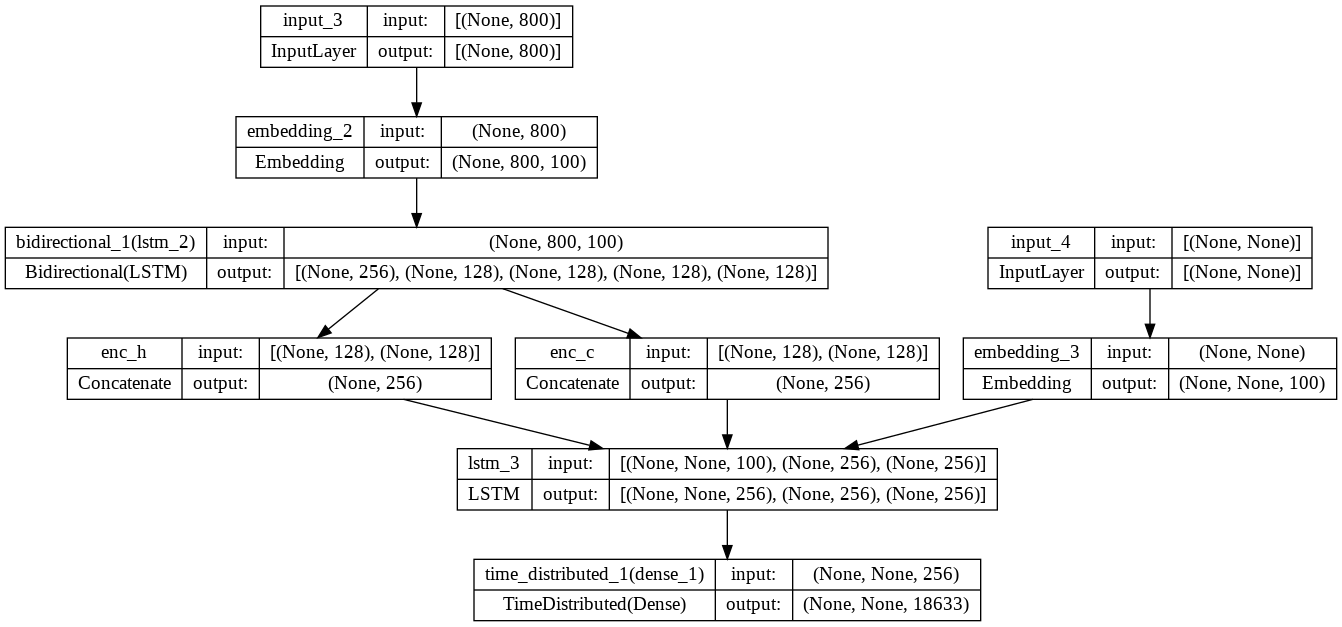

In [ ]:
latent_dim = 128
# Encoder
enc_input = Input(shape=(maxlen_text, ))
enc_embed = Embedding(t_max_features, embed_dim, input_length=maxlen_text, weights=[t_embed], trainable=False)(enc_input)
enc_lstm = Bidirectional(LSTM(latent_dim, return_state=True))
enc_output, enc_fh, enc_fc, enc_bh, enc_bc = enc_lstm(enc_embed)
enc_h = Concatenate(axis=-1, name='enc_h')([enc_fh, enc_bh])
enc_c = Concatenate(axis=-1, name='enc_c')([enc_fc, enc_bc])
#Decoder
dec_input = Input(shape=(None, ))
dec_embed = Embedding(s_max_features, embed_dim, weights=[s_embed], trainable=False)(dec_input)
dec_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.2)
dec_outputs, _, _ = dec_lstm(dec_embed, initial_state=[enc_h, enc_c])

dec_dense = TimeDistributed(Dense(s_max_features, activation='softmax'))
dec_output = dec_dense(dec_outputs)

model = Model([enc_input, dec_input], dec_output)
model.summary()

plot_model(
    model,
    to_file='/content/drive/MyDrive/Statistical Software - MSDS Fall 2022 (1)/Data/seq2seq_encoder_decoder.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96)

In [ ]:
# Reduced batch size from 128 to 4 to make 3 epochs run because of memory issue
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop')
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
model.fit([train_x, train_y[:, :-1]], train_y.reshape(train_y.shape[0], train_y.shape[1], 1)[:, 1:], epochs=3, callbacks=[early_stop], batch_size=4, verbose=1, validation_data=([val_x, val_y[:, :-1]], val_y.reshape(val_y.shape[0], val_y.shape[1], 1)[:, 1:]))

Epoch 1/3
   11/10000 [..............................] - ETA: 2:15:42 - loss: 2.3920

KeyboardInterrupt: ignored

## Inference

In [ ]:
enc_model = Model(inputs=enc_input, outputs=[enc_h, enc_c])

dec_init_state_h = Input(shape=(latent_dim*2, ))
dec_init_state_c = Input(shape=(latent_dim*2, ))

dec_out, dec_h, dec_c = dec_lstm(dec_embed, initial_state=[dec_init_state_h, dec_init_state_c])
dec_final = dec_dense(dec_out)

dec_model = Model([dec_input]+[dec_init_state_h, dec_init_state_c], [dec_final]+[dec_h, dec_c])

In [ ]:
def generate_summary(input_seq):
    h, c = enc_model.predict(input_seq)
    
    next_token = np.zeros((1, 1))
    next_token[0, 0] = s_tokenizer.word_index['sostok']
    output_seq = ''
    
    stop = False
    count = 0
    
    while not stop:
        if count > 100:
            break
        decoder_out, state_h, state_c = dec_model.predict([next_token]+[h, c])
        token_idx = np.argmax(decoder_out[0, -1, :])
        
        if token_idx == s_tokenizer.word_index['eostok']:
            stop = True
        elif token_idx > 0 and token_idx != s_tokenizer.word_index['sostok']:
            token = s_tokenizer.index_word[token_idx]
            output_seq = output_seq + ' ' + token
        
        next_token = np.zeros((1, 1))
        next_token[0, 0] = token_idx
        h, c = state_h, state_c
        count += 1
        
    return output_seq

In [ ]:
test_inputs = [clean_text(sent) for sent in test_df.article]
test_inputs = t_tokenizer.texts_to_sequences(list(test_inputs))
test_inputs = pad_sequences(test_inputs, maxlen=maxlen_text, padding='post')

In [ ]:
hyps = []
with open('/content/drive/MyDrive/Statistical Software - MSDS Fall 2022 (1)/Data/result_extractive_abstractive_50000(500).csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['Article', 'Original Summary', 'Model Output'])
    for i in range(500):
        our_summ = generate_summary(test_inputs[i].reshape(1, maxlen_text))
        hyps.append(our_summ)
        writer.writerow([test_df.article[i], test_df.highlights[i], our_summ])

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 21ms/step


## ROUGE SCORE

In [ ]:
rouge = Rouge()
rouge.get_scores(hyps, test_df.highlights, avg=True, ignore_empty=True)

{'rouge-1': {'r': 0.07268739004515487,
  'p': 0.3062398405621392,
  'f': 0.1124737907514485},
 'rouge-2': {'r': 0.008261592794523405,
  'p': 0.03230515037275042,
  'f': 0.012526618863146563},
 'rouge-l': {'r': 0.06909457204078287,
  'p': 0.2946922482876752,
  'f': 0.10719769083978054}}